# EDA, fill null with median

In [11]:
df_raw = pd.read_csv('/content/STORM_RAW_0.3.csv')

In [12]:
for column in ['LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'TotalDeaths', 'NoInjured', 'TotalDamage(000US$)']:
  median_value = df_raw[column].median()
  df_raw[column] = df_raw[column].fillna(median_value)

In [13]:
df_raw['TotalDamageAdjusted(000US$)'] = (df_raw['TotalDamage(000US$)'] / df_raw['CPI']) * 100

In [14]:
x_label = ['North_East', 'North_West', 'Red_River_Delta', 'North_Central_Coast', 'South_Central_Coast', 'Central_Highlands', 'South_East', 'Mekong_River_Delta']
map_dict = {i: name for i, name in enumerate(x_label, start=1)}

df_raw['MainLandfallLocation'] = df_raw['MainLandfallLocation'].map(map_dict)

In [17]:
df_raw = df_raw.drop(['OFDAResponse', 'Appeal', 'Declaration','CPI'], axis=1)

KeyError: "['OFDAResponse', 'Appeal', 'Declaration', 'CPI'] not found in axis"

In [20]:
df_raw.sample(5)

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$)
82,STORM_NAN_2000_4,NaN,2000,8.0,Storm,Storm (General),Mekong_River_Delta,0,0.0,70.0,989.0,3.0,3.0,35.0,59.482689
52,STORM_ANGELA_1992,Angela,1992,10.0,Storm,Tropical cyclone,Central_Highlands,1,0.0,74.0,992.0,47.0,17.0,18000.0,37542.133505
81,STORM_NAN_2000_3,NaN,2000,8.0,Storm,Storm (General),Central_Highlands,0,0.0,92.0,989.0,1.0,77.0,19400.0,32970.404810
4,STORM_KATE_1964,Kate,1964,11.0,Storm,Tropical cyclone,Central_Highlands,1,0.0,130.0,970.0,0.0,19.5,3000.0,28306.223466
104,STORM_PEIPAH_2007,Peipah,2007,11.0,Storm,Tropical cyclone,South_East,1,1.0,37.0,1007.0,17.5,19.5,19400.0,27382.259119


In [21]:
df = pd.read_csv('/content/STORM_RAW_1.csv')

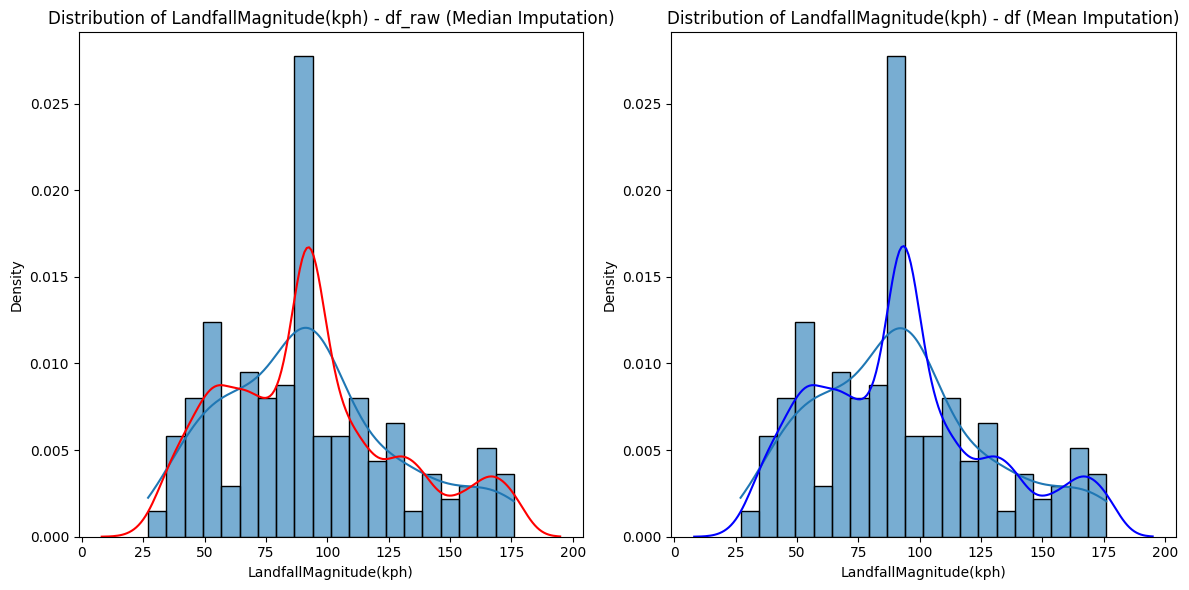

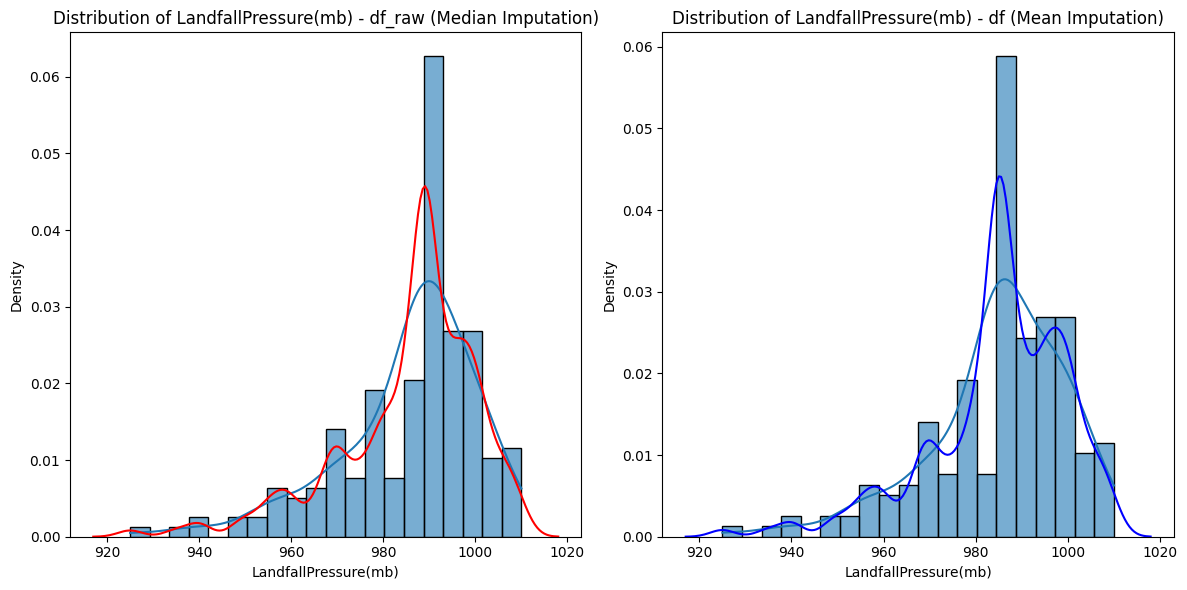

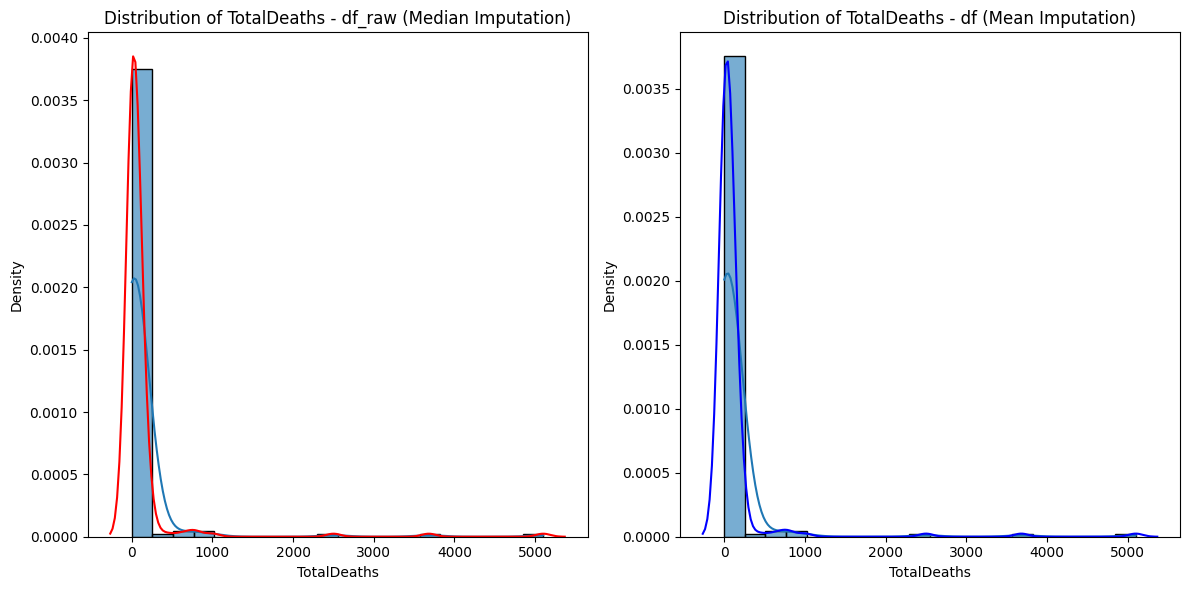

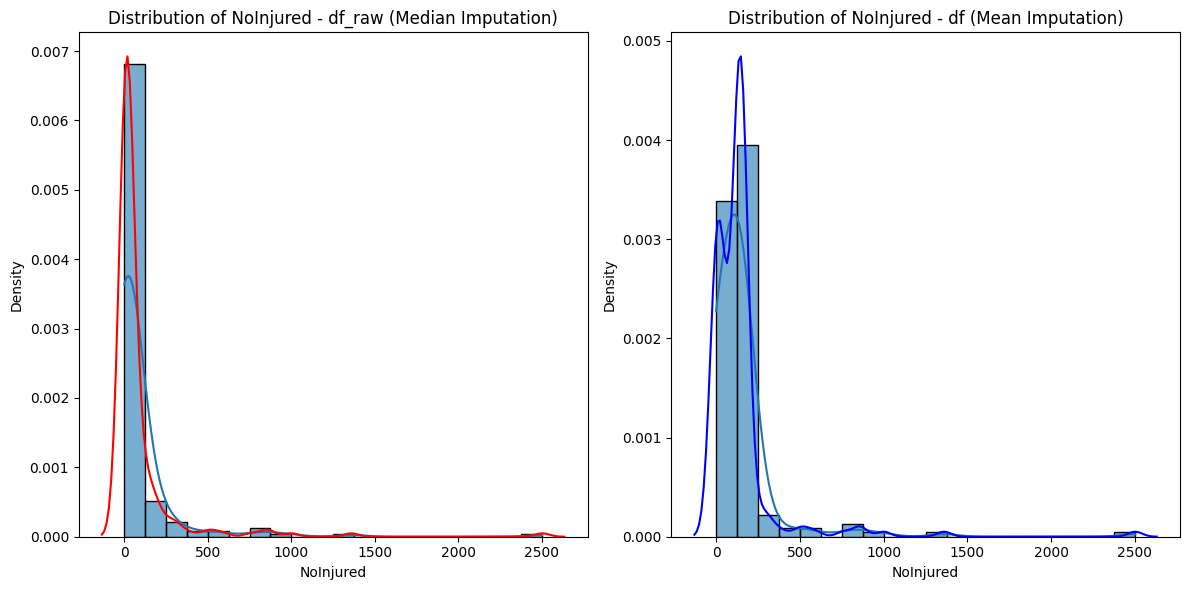

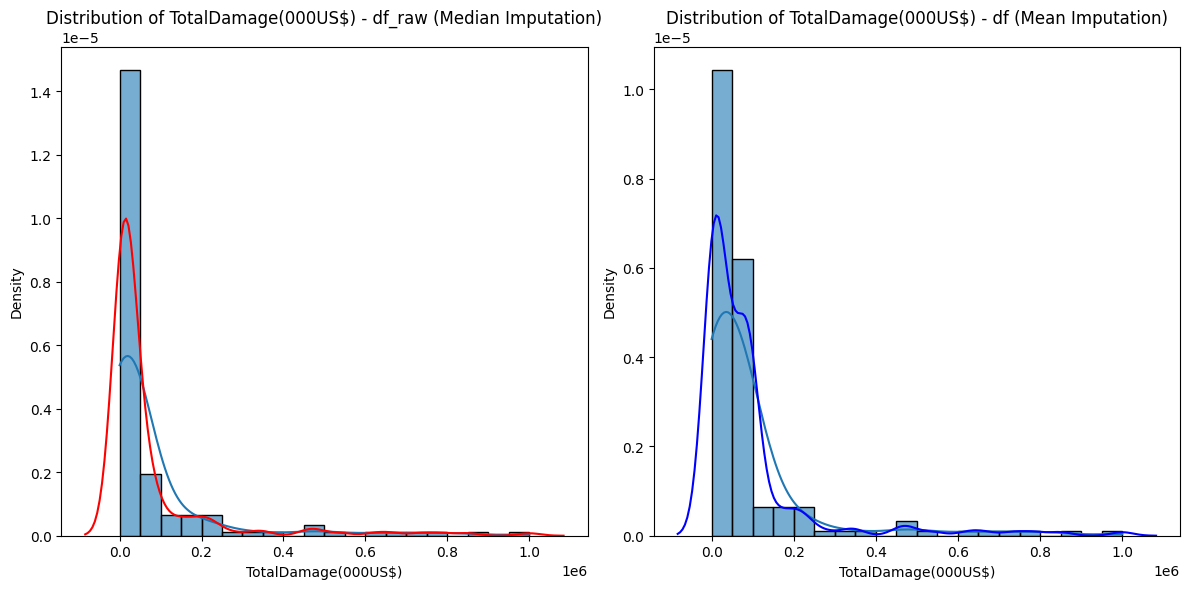

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to compare
columns_to_compare = ['LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'TotalDeaths', 'NoInjured', 'TotalDamage(000US$)']

# Loop through each column and create comparison plots
for col in columns_to_compare:
    plt.figure(figsize=(12, 6))

    # Distribution of the column in df_raw (median-imputed data)
    plt.subplot(1, 2, 1)
    sns.histplot(df_raw[col], kde=True, bins=20, stat="density", alpha=0.6)
    sns.kdeplot(df_raw[col], bw_adjust=0.5, color='red')
    plt.title(f'Distribution of {col} - df_raw (Median Imputation)')
    plt.xlabel(col)
    plt.ylabel('Density')

    # Distribution of the column in df (mean-imputed data)
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, bins=20, stat="density", alpha=0.6)
    sns.kdeplot(df[col], bw_adjust=0.5, color='blue')
    plt.title(f'Distribution of {col} - df (Mean Imputation)')
    plt.xlabel(col)
    plt.ylabel('Density')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# test siu nhanh cái model (trong colab)

target: death, injure, total dmg adjust . metric: mse, terminate the large error in predict dmg, phu hop voi gbms

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_csv('/content/df2_processed_data.csv')

In [25]:
df

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9.0,Storm,Tropical cyclone,8,0,0.0,0.0,0.0,0.0,92.0,989.0,1000.0,19.5,19400.0,211879.850745,9.156133
1,STORM_VIOLET_1964,Violet,1964,9.0,Storm,Tropical cyclone,4,1,1.0,NaN,NaN,NaN,92.0,989.0,17.5,19.5,10000.0,94354.078220,10.598376
2,STORM_IRIS_1964,Iris,1964,11.0,Storm,Tropical cyclone,5,1,0.0,NaN,NaN,NaN,150.0,960.0,5100.0,19.5,70000.0,660478.547543,10.598376
3,STORM_JOAN_1964,Joan,1964,11.0,Storm,Tropical cyclone,5,1,0.0,NaN,NaN,NaN,130.0,980.0,2500.0,19.5,15000.0,141531.117331,10.598376
4,STORM_KATE_1964,Kate,1964,11.0,Storm,Tropical cyclone,6,1,0.0,NaN,NaN,NaN,130.0,970.0,0.0,19.5,3000.0,28306.223466,10.598376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,STORM_KOMPASU_2021,Kompasu,2021,10.0,Storm,Tropical cyclone,4,0,0.0,NaN,NaN,NaN,46.0,1002.0,0.0,0.0,0.0,0.000000,92.590193
180,STORM_NAN_2022,NaN,2022,5.0,Storm,Storm (General),1,1,1.0,0.0,0.0,0.0,92.0,989.0,9.0,19.5,19400.0,19400.000000,100.000000
181,STORM_NORU(KARDING)_2022,Noru(Karding),2022,9.0,Storm,Storm surge,5,1,0.0,0.0,0.0,0.0,176.0,949.0,9.0,62.0,108300.0,108300.000000,100.000000
182,STORM_SONCA_2022,Sonca,2022,10.0,Storm,Tropical cyclone,5,1,1.0,0.0,0.0,0.0,55.0,1000.0,19.0,110.0,65000.0,65000.000000,100.000000


In [20]:
# prompt: delete col 	OFDAResponse	Appeal	Declaration and CPI

df = df.drop(['OFDAResponse', 'Appeal', 'Declaration','CPI'], axis=1)


In [26]:

df2 = pd.read_csv('/content/STORM_RAW_1(2).csv')
df['MainLandfallLocation'] = df2['MainLandfallLocation']
df['LandfallMagnitude(kph)'] = df2['LandfallMagnitude(kph)']
df['LandfallPressure(mb)'] = df2['LandfallPressure(mb)']
df['TotalDeaths'] = df2['TotalDeaths']
df['NoInjured'] = df2['NoInjured']
df['TotalDamage(000US$)'] = df2['TotalDamage(000US$)']
df['TotalDamageAdjusted(000US$)'] = df2['TotalDamageAdjusted(000US$)']


In [27]:
df2

,Unnamed: 0,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,0,STORM_NAN_1953,NaN,1953,9.0,Storm,Tropical cyclone,Mekong River Delta,0,1.0,0,0,0,93,985,1000,146,89730,139143.00,9.156.132.559
1,1,STORM_VIOLET_1964,Violet,1964,9.0,Storm,Tropical cyclone,North Central Coast,1,1.0,0,0,0,93,985,124,146,10000,94354.08,1.059.837.602
2,2,STORM_IRIS_1964,Iris,1964,11.0,Storm,Tropical cyclone,South Central Coast,1,0.0,0,0,0,150,960,5100,146,70000,660478.55,1.059.837.602
3,3,STORM_JOAN_1964,Joan,1964,11.0,Storm,Tropical cyclone,South Central Coast,1,0.0,0,0,0,130,980,2500,146,15000,141531.12,1.059.837.602
4,4,STORM_KATE_1964,Kate,1964,11.0,Storm,Tropical cyclone,Central Highlands,1,0.0,0,0,0,130,970,0,146,3000,28306.22,1.059.837.602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,179,STORM_KOMPASU_2021,Kompasu,2021,10.0,Storm,Tropical cyclone,North Central Coast,0,0.0,0,0,0,46,1002,0,0,0,0.00,9.259.019.293
180,180,STORM_NAN_2022,NaN,2022,5.0,Storm,Storm (General),NorthEast,1,1.0,0,0,0,93,985,9,146,89730,139143.00,100
181,181,STORM_NORU(KARDING)_2022,Noru(Karding),2022,9.0,Storm,Storm surge,South Central Coast,1,0.0,0,0,0,176,949,9,62,108300,108300.00,100
182,182,STORM_SONCA_2022,Sonca,2022,10.0,Storm,Tropical cyclone,South Central Coast,1,1.0,0,0,0,55,1000,19,110,65000,65000.00,100


## test one hot encoding

In [9]:
# Step 1: Create a mapping for the specific landfall labels
landfall_mapping = {
    'Đông Bắc Bộ': 1,
    'Tây Bắc Bộ': 2,
    'Đồng Bằng Sông Hồng (Hà Nội)': 3,
    'Bắc Trung Bộ': 4,
    'Nam Trung Bộ (Đà Nẵng)': 5,
    'Tây Nguyên': 6,
    'Đông Nam Bộ (TPHCM)': 7,
    'Đồng bằng sông cửu long': 8
}

# Step 2: Map the 'MainLandfallLocation' column to these numerical values
df['MainLandfallLocation'] = df['MainLandfallLocation'].map(landfall_mapping)

# Step 3: Apply one-hot encoding for remaining categorical columns like DisasterType and DisasterSubtype
categorical_cols = ['DisasterType', 'DisasterSubtype']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 4: Standardize numerical columns LandfallMagnitude(kph) and LandfallPressure(mb)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['LandfallMagnitude(kph)', 'LandfallPressure(mb)']] = scaler.fit_transform(df[['LandfallMagnitude(kph)', 'LandfallPressure(mb)']])

# Display the processed DataFrame to verify changes
df.head()


,ID,EventName,Year,Month,MainLandfallLocation,Flood,Slide,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,...,TotalDamage(000US$),TotalDamageAdjusted(000US$),DisasterSubtype_Hail,DisasterSubtype_Lightning/Thunderstorms,DisasterSubtype_Severe weather,DisasterSubtype_Storm (General),DisasterSubtype_Storm surge,DisasterSubtype_Tornado,DisasterSubtype_Tropical cyclone,DisasterSubtype_Tropical depression
0,STORM_NAN_1953,NaN,1953,9.0,NaN,0,0.0,-0.016006,0.230818,1000.0,...,19400.0,211879.850745,False,False,False,False,False,False,True,False
1,STORM_VIOLET_1964,Violet,1964,9.0,NaN,1,1.0,-0.016006,0.230818,17.5,...,10000.0,94354.078220,False,False,False,False,False,False,True,False
2,STORM_IRIS_1964,Iris,1964,11.0,NaN,1,0.0,1.610786,-1.690625,5100.0,...,70000.0,660478.547543,False,False,False,False,False,False,True,False
3,STORM_JOAN_1964,Joan,1964,11.0,NaN,1,0.0,1.049823,-0.365492,2500.0,...,15000.0,141531.117331,False,False,False,False,False,False,True,False
4,STORM_KATE_1964,Kate,1964,11.0,NaN,1,0.0,1.049823,-1.028059,0.0,...,3000.0,28306.223466,False,False,False,False,False,False,True,False


## XGBOOST

In [10]:
predictors = ['LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide', 'Year', 'Month'] + \
             [col for col in df.columns if col.startswith('MainLandfallLocation_') or col.startswith('DisasterSubtype_')]

# Exclude highly correlated variables like TotalDamage and focus on TotalDamageAdjusted
target = 'TotalDamageAdjusted(000US$)'

X = df[predictors]
y = df[target]

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)

In [12]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3, 5],
    'subsample': [1.0]
}

# Set up cross-validation with grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Step 4: Train the model using cross-validation to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Step 5: Use the best found model to make predictions
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Step 6: Evaluate the model using MSE for both training and testing sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Step 7: Analyze feature importance from the best model
feature_importance = best_model.feature_importances_

# Create a DataFrame to display feature importance alongside their names
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Output the results: MSE and feature importance
mse_train, mse_test, grid_search.best_params_, importance_df.head(10)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


(5555024884.479379,
 44905245322.04374,
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0},
                                     Feature  Importance
 0                    LandfallMagnitude(kph)    0.235013
 3                                     Slide    0.192924
 4                                      Year    0.187337
 1                      LandfallPressure(mb)    0.138850
 2                                     Flood    0.078305
 5                                     Month    0.076837
 12         DisasterSubtype_Tropical cyclone    0.057321
 13      DisasterSubtype_Tropical depression    0.033413
 6                      DisasterSubtype_Hail    0.000000
 7   DisasterSubtype_Lightning/Thunderstorms    0.000000)

In [17]:
df


,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9.0,Storm,Tropical cyclone,8,0,0.0,0.0,0.0,0.0,92.0,989.0,1000.0,19.5,19400.0,211879.850745,9.156133
1,STORM_VIOLET_1964,Violet,1964,9.0,Storm,Tropical cyclone,4,1,1.0,NaN,NaN,NaN,92.0,989.0,17.5,19.5,10000.0,94354.078220,10.598376
2,STORM_IRIS_1964,Iris,1964,11.0,Storm,Tropical cyclone,5,1,0.0,NaN,NaN,NaN,150.0,960.0,5100.0,19.5,70000.0,660478.547543,10.598376
3,STORM_JOAN_1964,Joan,1964,11.0,Storm,Tropical cyclone,5,1,0.0,NaN,NaN,NaN,130.0,980.0,2500.0,19.5,15000.0,141531.117331,10.598376
4,STORM_KATE_1964,Kate,1964,11.0,Storm,Tropical cyclone,6,1,0.0,NaN,NaN,NaN,130.0,970.0,0.0,19.5,3000.0,28306.223466,10.598376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,STORM_KOMPASU_2021,Kompasu,2021,10.0,Storm,Tropical cyclone,4,0,0.0,NaN,NaN,NaN,46.0,1002.0,0.0,0.0,0.0,0.000000,92.590193
180,STORM_NAN_2022,NaN,2022,5.0,Storm,Storm (General),1,1,1.0,0.0,0.0,0.0,92.0,989.0,9.0,19.5,19400.0,19400.000000,100.000000
181,STORM_NORU(KARDING)_2022,Noru(Karding),2022,9.0,Storm,Storm surge,5,1,0.0,0.0,0.0,0.0,176.0,949.0,9.0,62.0,108300.0,108300.000000,100.000000
182,STORM_SONCA_2022,Sonca,2022,10.0,Storm,Tropical cyclone,5,1,1.0,0.0,0.0,0.0,55.0,1000.0,19.0,110.0,65000.0,65000.000000,100.000000


model overfitting , sẽ sửa ratio train test,  LandfallMagnitude là feature quan trọng nhất, Year cũng có tác động rất lớn vào thiệt hại, flood và slide đồng thời cũng có tác dụng lớn. DisasterSubtype k quan trọng lắm.

## LightGBM , test sau

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Prepare the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set up the parameters for training
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model
num_round = 100
bst = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Display the MSE results
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's l2: 2.44519e+10	valid_1's l2: 3.84964e+10
Training MSE: 24451882528.490303
Testing MSE: 38496355728.50414


In [14]:
# Feature importance
feature_importance = bst.feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
importance_df.head(10)

,Feature,Importance
4,Year,72
1,LandfallPressure(mb),42
5,Month,42
0,LandfallMagnitude(kph),36
3,Slide,30
12,DisasterSubtype_Tropical cyclone,7
2,Flood,0
6,DisasterSubtype_Hail,0
7,DisasterSubtype_Lightning/Thunderstorms,0
8,DisasterSubtype_Severe weather,0


đã sửa ratio train test 7-3 và có vẻ fit hơn, nhưng vẫn cần cải thiện dùng regularization như l1 l2 hoặc giảm max_depth
theo model này năm lại là ảnh hưởng nhiều nhất r mới lần lượt tới LandfallMagnitude(kph), LandfallPressure(mb), Month
month thì khá ngạc nhiên, chắc là pattern theo tháng như gió mùa, trời trở,..
khác với model kia thì slide với subtype là 0 quan trọng, sẽ fix one hot encode thành các khu vực . remove subtype chắc hợp lý
